In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import concurrent.futures
import numpy as np

In [2]:
# Load data
file_path = "/Users/daniellott2/Documents/stock-program/stocks_calc_final.csv"
df = pd.read_csv(file_path)

In [3]:
# Descriptive Statistics
print("\nDescriptive statistics of the dataset:")
print(df.describe())


Descriptive statistics of the dataset:
               Open          High           Low         Close  Adjusted Close  \
count  3.754357e+06  3.754357e+06  3.754357e+06  3.754357e+06    3.754357e+06   
mean   8.143941e+01  8.240278e+01  8.045152e+01  8.145065e+01    6.715605e+01   
std    1.867656e+02  1.888396e+02  1.846871e+02  1.868087e+02    2.139462e+02   
min    1.000000e-04  1.000000e-04  1.000000e-04  1.000000e-04    1.000000e-04   
25%    2.734000e+01  2.774000e+01  2.693000e+01  2.734000e+01    1.491977e+01   
50%    4.645000e+01  4.700000e+01  4.585000e+01  4.645000e+01    3.013736e+01   
75%    7.956000e+01  8.040000e+01  7.870000e+01  7.958000e+01    6.158000e+01   
max    9.839980e+03  9.912560e+03  9.768290e+03  9.892300e+03    1.185921e+04   

             Volume  Dividend Amount  Split Coefficient      Earnings  \
count  3.754357e+06     3.754357e+06       3.754357e+06  3.177794e+06   
mean   4.138245e+06     5.089995e-03       1.000215e+00  1.234860e+00   
std    1.31

In [7]:
# Sample the data (e.g., 10% of the data)
df_sampled = df.sample(frac=1, random_state=42)

In [8]:
# Feature engineering and data preparation function
def prepare_features(df):
    df['Price_Change_1Y'] = (df['Adjusted Close'].shift(-252) - df['Adjusted Close']) / df['Adjusted Close']
    df['Price_Change_5Y'] = (df['Adjusted Close'].shift(-252*5) - df['Adjusted Close']) / df['Adjusted Close']
    df['Price_Change_10Y'] = (df['Adjusted Close'].shift(-252*10) - df['Adjusted Close']) / df['Adjusted Close']
    return df.dropna()

In [9]:
# Use multithreading for data preparation
with concurrent.futures.ThreadPoolExecutor() as executor:
    future = executor.submit(prepare_features, df_sampled)
    df = future.result()

In [10]:
# Filter data to include only relevant columns and ignore negative P/E ratios and P/E ratios >= 100
df = df[['P/E Ratio', 'Price_Change_1Y', 'Price_Change_5Y', 'Price_Change_10Y']]
df = df[(df['P/E Ratio'] >= 0) & (df['P/E Ratio'] < 100)]

In [11]:
# Remove rows with missing or infinite P/E ratios
df = df.replace([np.inf, -np.inf], np.nan).dropna()

In [12]:
# Function to calculate mean return for a given P/E ratio range
def calculate_mean_return(df, lower, upper, period):
    filtered_df = df[(df['P/E Ratio'] >= lower) & (df['P/E Ratio'] < upper)]
    if not filtered_df.empty:
        return filtered_df[period].mean()
    else:
        return -np.inf  # Return negative infinity if no data points in the range

In [13]:
# Function to find the optimal P/E ratio range for a given period
def find_optimal_range(df, period):
    best_mean_return = -np.inf
    best_range = (0, 0)

    for lower in np.arange(0, 30, 0.1):
        for upper in np.arange(lower + 0.1, 30.1, 0.1):
            filtered_df = df[(df['P/E Ratio'] >= lower) & (df['P/E Ratio'] < upper)]
            percent_in_range = len(filtered_df) / len(df) * 100
            if percent_in_range > 1:
                mean_return = calculate_mean_return(df, lower, upper, period)
                if mean_return > best_mean_return:
                    best_mean_return = mean_return
                    best_range = (lower, upper)

    return best_range, best_mean_return

In [14]:
# Calculate the percentage of data with P/E ratio in the range 0-5
pe_ratio_0_5 = df[(df['P/E Ratio'] >= 0) & (df['P/E Ratio'] < 5)]
percent_0_5 = len(pe_ratio_0_5) / len(df) * 100
print(f"Percentage of data with P/E ratio in the range 0-5: {percent_0_5:.2f}%")

Percentage of data with P/E ratio in the range 0-5: 0.40%


In [15]:
# Find optimal ranges for 1-year, 5-year, and 10-year periods
optimal_range_1Y, best_mean_return_1Y = find_optimal_range(df, 'Price_Change_1Y')
print(f"Optimal P/E Ratio range for 1-year gains: {optimal_range_1Y} with mean return: {best_mean_return_1Y}")

Optimal P/E Ratio range for 1-year gains: (np.float64(0.0), np.float64(8.3)) with mean return: 15.851671426514178


In [16]:
optimal_range_5Y, best_mean_return_5Y = find_optimal_range(df, 'Price_Change_5Y')
print(f"Optimal P/E Ratio range for 5-year gains: {optimal_range_5Y} with mean return: {best_mean_return_5Y}")


Optimal P/E Ratio range for 5-year gains: (np.float64(0.30000000000000004), np.float64(8.499999999999998)) with mean return: 15.797037988154552


In [17]:
optimal_range_10Y, best_mean_return_10Y = find_optimal_range(df, 'Price_Change_10Y')
print(f"Optimal P/E Ratio range for 10-year gains: {optimal_range_10Y} with mean return: {best_mean_return_10Y}")

Optimal P/E Ratio range for 10-year gains: (np.float64(15.700000000000001), np.float64(16.999999999999996)) with mean return: 18.33305496224072


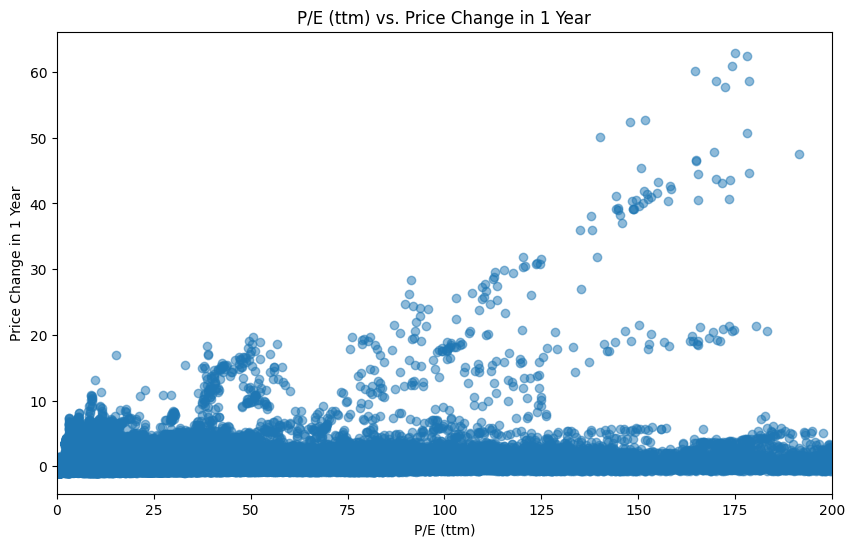

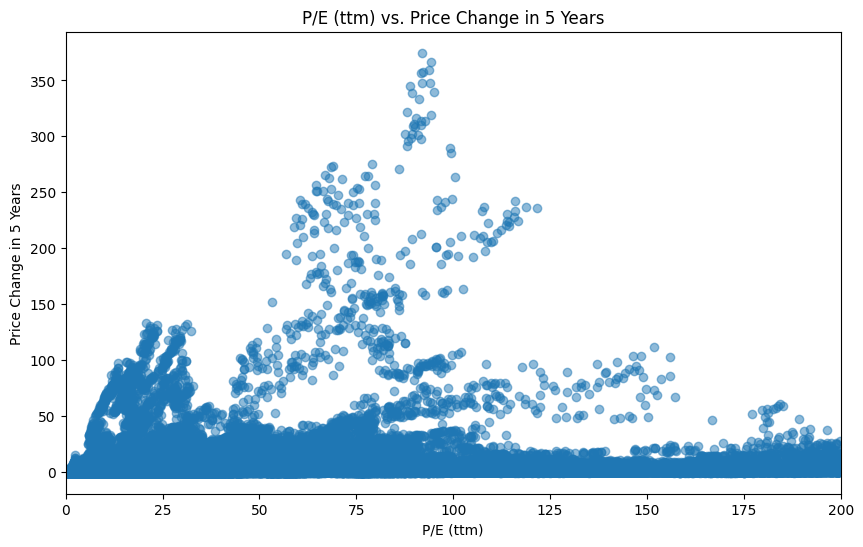

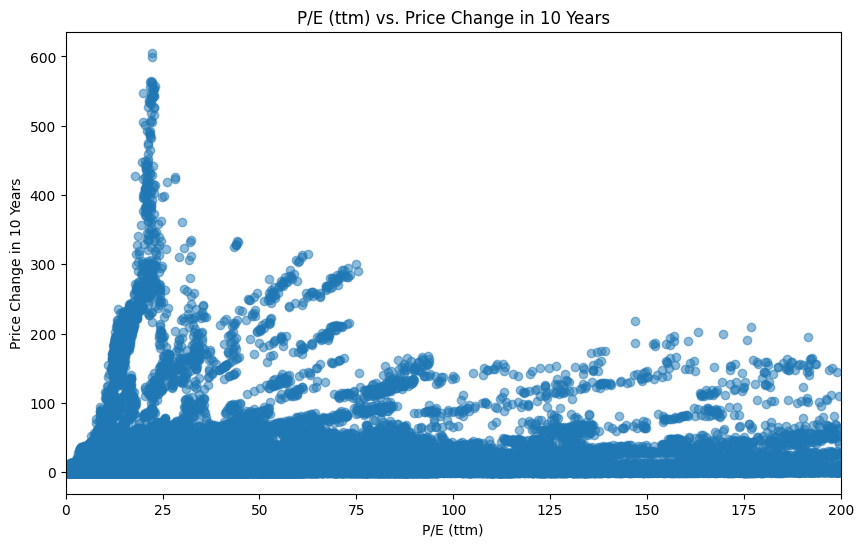

/var/folders/wm/fydrjt2543sch7051n5t7ygc0000gs/T/ipykernel_20844/824239813.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_5yr_filtered['PE_Bin'] = pd.cut(df_5yr_filtered['P/E (ttm)'], bins)
/var/folders/wm/fydrjt2543sch7051n5t7ygc0000gs/T/ipykernel_20844/824239813.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = df_5yr_filtered.groupby('PE_Bin')['Price_Change_5Y'].median()


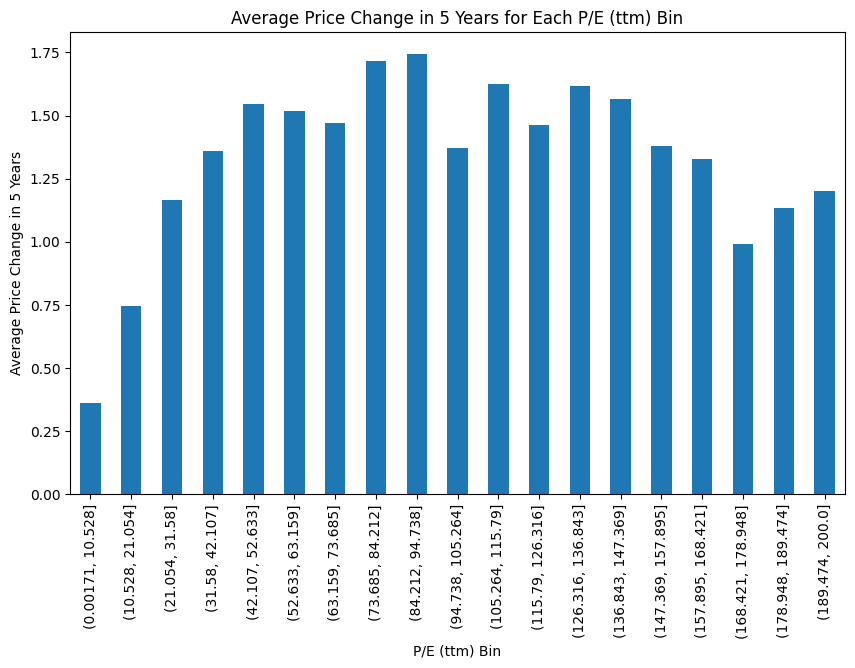

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data from CSV files
df_1yr = pd.read_csv("../stocks_with_1yr_price_change.csv")
df_5yr = pd.read_csv("../stocks_with_5yr_price_change.csv")
df_10yr = pd.read_csv("../stocks_with_10yr_price_change.csv")

# Convert 'Date' column to datetime
df_1yr['Date'] = pd.to_datetime(df_1yr['Date'])
df_5yr['Date'] = pd.to_datetime(df_5yr['Date'])
df_10yr['Date'] = pd.to_datetime(df_10yr['Date'])

# Filter data for P/E (ttm) values in the range of -100 to 100+
df_1yr_filtered = df_1yr[(df_1yr['P/E (ttm)'] >= 0) & (df_1yr['P/E (ttm)'] <= 200)]
df_5yr_filtered = df_5yr[(df_5yr['P/E (ttm)'] >= 0) & (df_5yr['P/E (ttm)'] <= 200)]
df_10yr_filtered = df_10yr[(df_10yr['P/E (ttm)'] >= 0) & (df_10yr['P/E (ttm)'] <= 200)]

# Plot P/E (ttm) vs. Price Change in 1 Year
plt.figure(figsize=(10, 6))
plt.scatter(df_1yr_filtered['P/E (ttm)'], df_1yr_filtered['Price_Change_1Y'], alpha=0.5)
plt.xlabel("P/E (ttm)")
plt.ylabel("Price Change in 1 Year")
plt.title("P/E (ttm) vs. Price Change in 1 Year")
plt.xlim(0, 200)
plt.show()

# Plot P/E (ttm) vs. Price Change in 5 Years
plt.figure(figsize=(10, 6))
plt.scatter(df_5yr_filtered['P/E (ttm)'], df_5yr_filtered['Price_Change_5Y'], alpha=0.5)
plt.xlabel("P/E (ttm)")
plt.ylabel("Price Change in 5 Years")
plt.title("P/E (ttm) vs. Price Change in 5 Years")
plt.xlim(0, 200)
plt.show()

# Plot P/E (ttm) vs. Price Change in 10 Years
plt.figure(figsize=(10, 6))
plt.scatter(df_10yr_filtered['P/E (ttm)'], df_10yr_filtered['Price_Change_10Y'], alpha=0.5)
plt.xlabel("P/E (ttm)")
plt.ylabel("Price Change in 10 Years")
plt.title("P/E (ttm) vs. Price Change in 10 Years")
plt.xlim(0, 200)
plt.show()

# Plot the average 5-year price change for each P/E (ttm) ratio bin
plt.figure(figsize=(10, 6))
bins = np.linspace(df_10yr_filtered['P/E (ttm)'].min(), df_10yr_filtered['P/E (ttm)'].max(), 20)
df_10yr_filtered['PE_Bin'] = pd.cut(df_5yr_filtered['P/E (ttm)'], bins)
bin_means = df_10yr_filtered.groupby('PE_Bin')['Price_Change_10Y'].median()
bin_means.plot(kind='bar')
plt.xlabel("P/E (ttm) Bin")
plt.ylabel("Average Price Change in 10 Years")
plt.title("Average Price Change in 10 Years for Each P/E (ttm) Bin")
plt.show()

In [ ]:

import pandas as pd
from sklearn.linear_model import LinearRegression

df = pd.read_csv("../stocks_with_1yr_price_change.csv")

# Take a 10% sample
df_sample = df.sample(frac=0.1, random_state=42)

# Prepare features (X) and target (y)
X = df_sample[["Adjusted Close", "Volume", "P/E (ttm)", "MA_50", "MA_200"]]
y = df_sample["Price_Change_1Y"]

# Fit the model
model = LinearRegression()
model.fit(X, y)

# Print results
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)
print("R^2 Score:", model.score(X, y))


# Random Forest

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Read CSV files
df_1 = pd.read_csv("../stocks_with_1yr_price_change.csv")
df_5 = pd.read_csv("../stocks_with_5yr_price_change.csv")
df_10 = pd.read_csv("../stocks_with_10yr_price_change.csv")

# Take a % sample
df_sample_1 = df_1.sample(frac=.01, random_state=42)
df_sample_5 = df_5.sample(frac=.01, random_state=42)
df_sample_10 = df_10.sample(frac=.01, random_state=42)

# Sample one row per Symbol
# df_sample_1 = df_1.groupby('Symbol').sample(n=1)
# df_sample_5 = df_5.groupby('Symbol').sample(n=1)
# df_sample_10 = df_10.groupby('Symbol').sample(n=1)



# Features for models
features = ['Adjusted Close', 'Volume', 'P/E (ttm)', 'MA_50/Adj_Close', 'MA_200/Adj_Close'] # add 1-day change

# Random Forest for 1-year price change
X_1 = df_sample_1[features]
y_1 = df_sample_1['Price_Change_1Y']
model_rf_1 = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf_1.fit(X_1, y_1)

# Random Forest for 5-year price change
X_5 = df_sample_5[features]
y_5 = df_sample_5['Price_Change_5Y']
model_rf_5 = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf_5.fit(X_5, y_5)

# Random Forest for 10-year price change
X_10 = df_sample_10[features]
y_10 = df_sample_10['Price_Change_10Y']
model_rf_10 = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf_10.fit(X_10, y_10)

# Print results
def print_model_results(model, features, period):
    print(f"\nRandom Forest Results for {period}-year price change:")
    print("R² Score:", model.score(X_1, y_1))
    print("\nFeature Importances:")
    for feature, importance in zip(features, model.feature_importances_):
        print(f"{feature}: {importance:.4f}")

print_model_results(model_rf_1, features, 1)
print_model_results(model_rf_5, features, 5)
print_model_results(model_rf_10, features, 10)


Random Forest Results for 1-year price change:
R² Score: 0.8979726057040628

Feature Importances:
Adjusted Close: 0.0738
Volume: 0.0943
P/E (ttm): 0.1660
MA_50/Adj_Close: 0.1789
MA_200/Adj_Close: 0.4869

Random Forest Results for 5-year price change:
R² Score: -6.524833146775142

Feature Importances:
Adjusted Close: 0.2533
Volume: 0.1704
P/E (ttm): 0.2129
MA_50/Adj_Close: 0.1603
MA_200/Adj_Close: 0.2031

Random Forest Results for 10-year price change:
R² Score: -169.06151509732751

Feature Importances:
Adjusted Close: 0.2884
Volume: 0.2255
P/E (ttm): 0.2811
MA_50/Adj_Close: 0.0923
MA_200/Adj_Close: 0.1128


# Random Forest w/ Econ. Ind.

Loading data from /Users/daniellott2/Documents/stock-program/stocks_with_1yr_price_change.csv...
Data loaded successfully with 2652228 rows.
Available columns: ['Symbol', 'Date', 'Open', 'High', 'Low', 'Close', 'Adjusted Close', 'Volume', 'Dividend Amount', 'Split Coefficient', 'Earnings', 'P/E Ratio', 'EPS (ttm)', 'P/E (ttm)', 'CPI', 'Fed_Funds_Rate', 'GDP_Per_Capita', 'Inflation_Rate', 'Real_GDP', 'Treasury_Yield', 'Unemployment_Rate', 'MA_50', 'MA_200', 'Price_Change_1Y', 'Price_Change_5Y', 'Price_Change_10Y', 'MA_50/Adj_Close', 'MA_200/Adj_Close']
Economic indicators found: ['CPI', 'Fed_Funds_Rate', 'GDP_Per_Capita', 'Inflation_Rate', 'Real_GDP', 'Treasury_Yield', 'Unemployment_Rate']
Model loaded successfully.
Using these available features: ['Adjusted Close', 'Volume', 'P/E (ttm)', 'MA_50/Adj_Close', 'MA_200/Adj_Close', 'CPI', 'Fed_Funds_Rate', 'GDP_Per_Capita', 'Inflation_Rate', 'Real_GDP', 'Treasury_Yield', 'Unemployment_Rate']
Training period: 2001 to 2017
Testing period: 2018

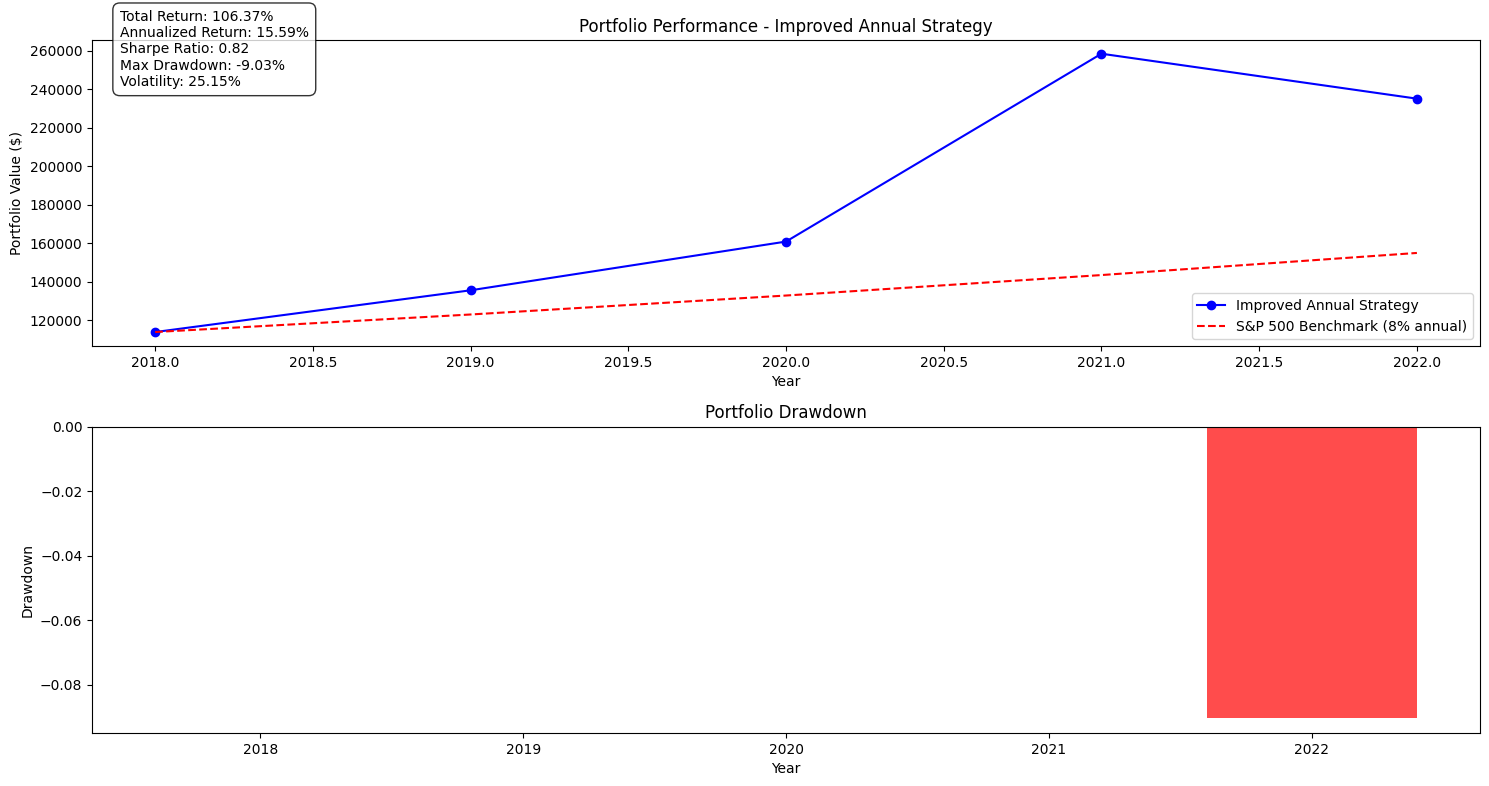

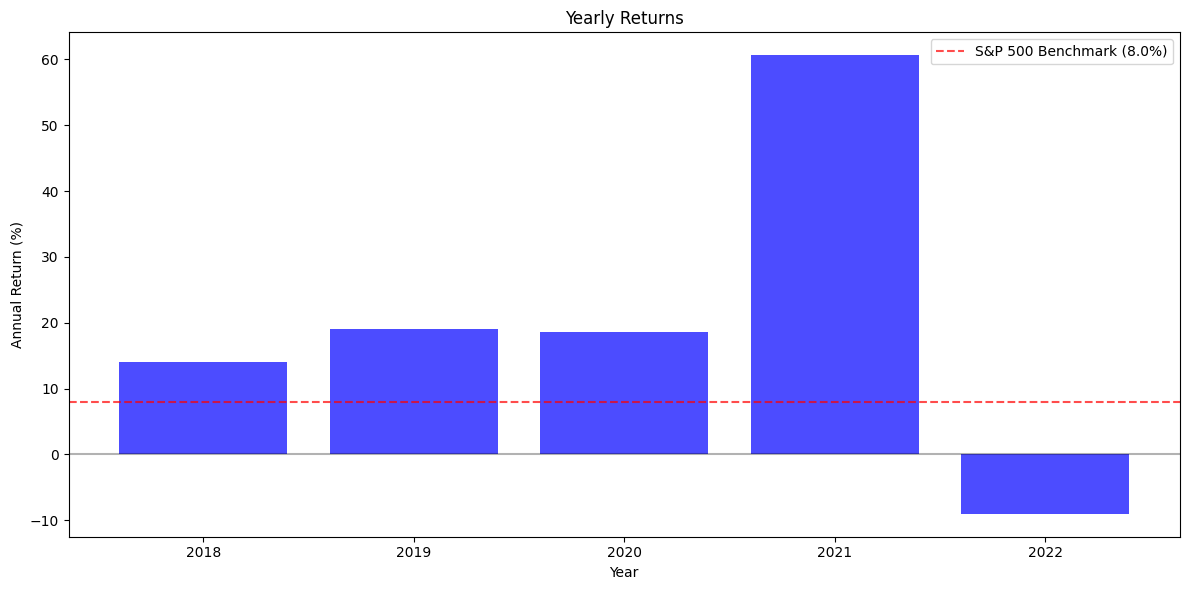


Yearly Position Statistics:
     Actual_Return                                      Contributed_Return
              mean       min        max       std count                sum
Year                                                                      
2018      0.140664 -0.505229   1.371579  0.360091    54           0.140664
2019      0.192093 -0.211546   0.619025  0.179267    54           0.192093
2020      0.188455 -0.495754   3.315298  0.643339    55           0.188455
2021      0.607702 -0.569836  10.791304  1.476460    56           0.607702
2022     -0.088582 -0.518119   0.652662  0.252380    56          -0.088582
Results saved to CSV files.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Read CSV files
df_1 = pd.read_csv("../stocks_with_1yr_price_change.csv")
df_5 = pd.read_csv("../stocks_with_5yr_price_change.csv")
df_10 = pd.read_csv("../stocks_with_10yr_price_change.csv")

# Check if economic indicators are already in the dataframes
print("Columns in df_1:", df_1.columns)

# If economic indicators are not already in the dataframes, they should be in the files loaded in DataAdjust.ipynb
# These indicators should already be merged in with the stocks data in the "stocks_final_with_economic_indicators.csv" step
# If the indicators are not already in your dataframes, you'd need to merge them

# Economic indicators to be added to features
econ_indicators = [
    'CPI', 
    'Fed_Funds_Rate', 
    'GDP_Per_Capita', 
    'Inflation_Rate', 
    'Real_GDP', 
    'Treasury_Yield', 
    'Unemployment_Rate'
]

# Sample one row per Symbol for more diversity in training
df_sample_1 = df_1.groupby('Symbol').sample(n=1)
df_sample_5 = df_5.groupby('Symbol').sample(n=1)
df_sample_10 = df_10.groupby('Symbol').sample(n=1)

# Original features
base_features = ['Adjusted Close', 'Volume', 'P/E (ttm)', 'MA_50/Adj_Close', 'MA_200/Adj_Close']

# Combined features (base features + economic indicators)
features = base_features + econ_indicators

# Check that all features are available in the dataframes
missing_features = [f for f in features if f not in df_sample_1.columns]
if missing_features:
    print(f"Warning: Missing features in dataframes: {missing_features}")
    print("Using only available features...")
    features = [f for f in features if f in df_sample_1.columns]

print(f"Using features: {features}")

# Random Forest for 1-year price change
X_1 = df_sample_1[features]
y_1 = df_sample_1['Price_Change_1Y']
model_rf_1 = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf_1.fit(X_1, y_1)

# Random Forest for 5-year price change
X_5 = df_sample_5[features]
y_5 = df_sample_5['Price_Change_5Y']
model_rf_5 = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf_5.fit(X_5, y_5)

# Random Forest for 10-year price change
X_10 = df_sample_10[features]
y_10 = df_sample_10['Price_Change_10Y']
model_rf_10 = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf_10.fit(X_10, y_10)

# Print results - fixed to use the correct X data for each model
def print_model_results(model, features, period, X_data, y_data):
    print(f"\nRandom Forest Results for {period}-year price change:")
    print(f"R² Score: {model.score(X_data, y_data):.4f}")
    print("\nFeature Importances:")
    
    # Sort features by importance for better visualization
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    for i in indices:
        print(f"{features[i]}: {importances[i]:.4f}")

print_model_results(model_rf_1, features, 1, X_1, y_1)
print_model_results(model_rf_5, features, 5, X_5, y_5)
print_model_results(model_rf_10, features, 10, X_10, y_10)

# Optional: Plot feature importances for 1-year prediction
import matplotlib.pyplot as plt

def plot_feature_importance(model, features, title):
    importances = model.feature_importances_
    indices = np.argsort(importances)
    
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_feature_importance(model_rf_1, features, 'Feature Importance for 1-Year Price Change Prediction')

# save models as pickle files
import pickle
with open('model_rf_1.pkl', 'wb') as f:
    pickle.dump(model_rf_1, f)
with open('model_rf_5.pkl', 'wb') as f:
    pickle.dump(model_rf_5, f)
with open('model_rf_10.pkl', 'wb') as f:
    pickle.dump(model_rf_10, f)

# Random Forest Backtesting

Loading data from /Users/daniellott2/Documents/stock-program/stocks_with_1yr_price_change.csv...
Data loaded successfully with 2652228 rows.
Available columns: ['Symbol', 'Date', 'Open', 'High', 'Low', 'Close', 'Adjusted Close', 'Volume', 'Dividend Amount', 'Split Coefficient', 'Earnings', 'P/E Ratio', 'EPS (ttm)', 'P/E (ttm)', 'CPI', 'Fed_Funds_Rate', 'GDP_Per_Capita', 'Inflation_Rate', 'Real_GDP', 'Treasury_Yield', 'Unemployment_Rate', 'MA_50', 'MA_200', 'Price_Change_1Y', 'Price_Change_5Y', 'Price_Change_10Y', 'MA_50/Adj_Close', 'MA_200/Adj_Close']
Economic indicators found: ['CPI', 'Fed_Funds_Rate', 'GDP_Per_Capita', 'Inflation_Rate', 'Real_GDP', 'Treasury_Yield', 'Unemployment_Rate']
Model loaded successfully.
Using these available features: ['Adjusted Close', 'Volume', 'P/E (ttm)', 'MA_50/Adj_Close', 'MA_200/Adj_Close', 'CPI', 'Fed_Funds_Rate', 'GDP_Per_Capita', 'Inflation_Rate', 'Real_GDP', 'Treasury_Yield', 'Unemployment_Rate']
Training period: 2001 to 2017
Testing period: 2018

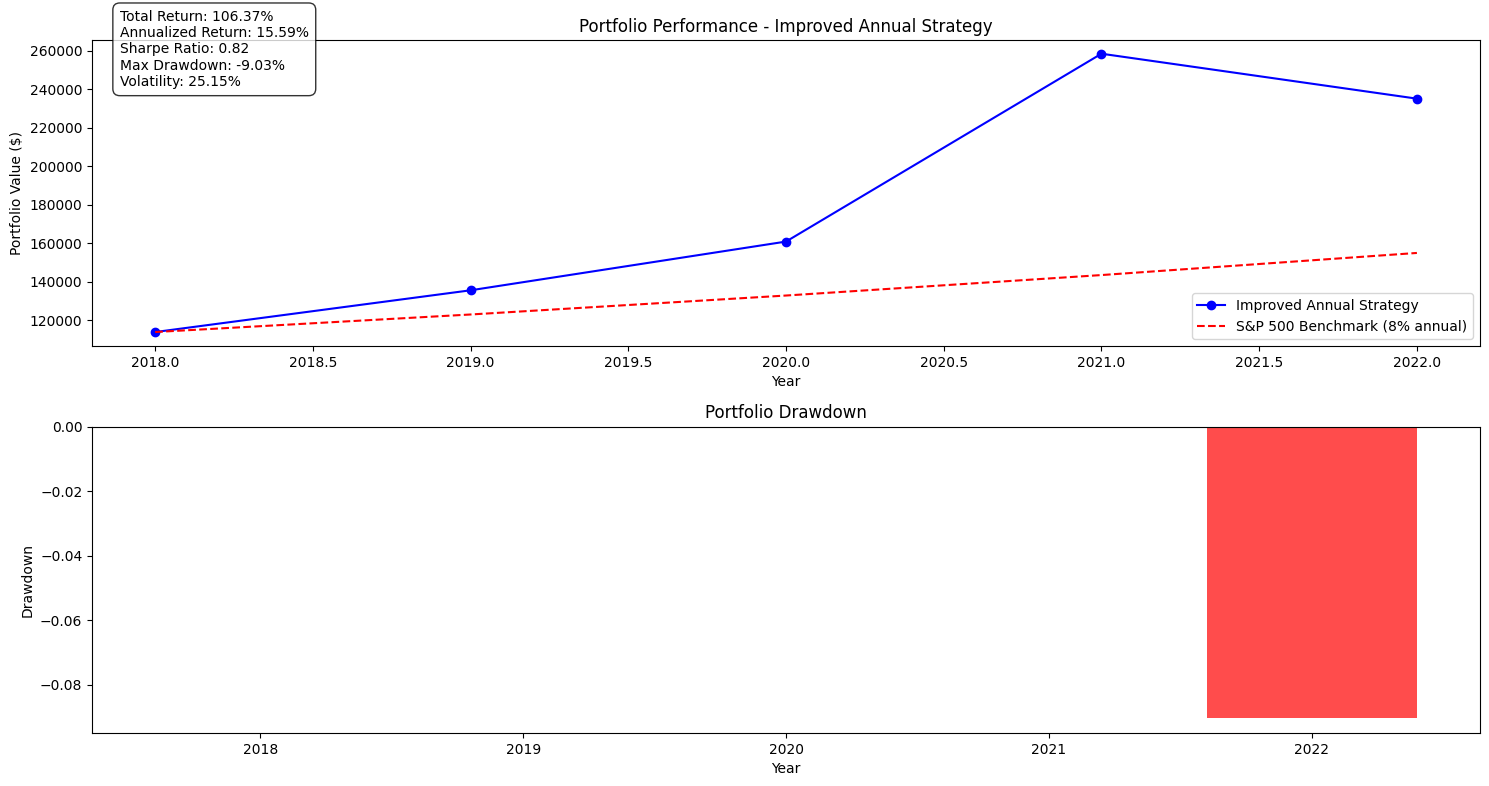

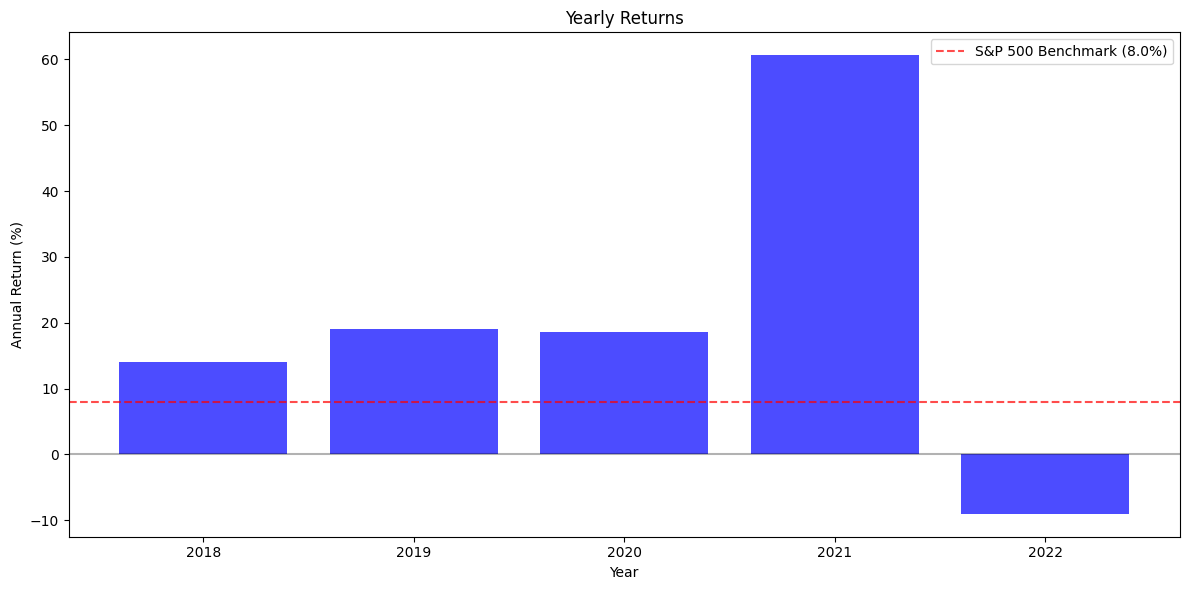


Yearly Position Statistics:
     Actual_Return                                      Contributed_Return
              mean       min        max       std count                sum
Year                                                                      
2018      0.140664 -0.505229   1.371579  0.360091    54           0.140664
2019      0.192093 -0.211546   0.619025  0.179267    54           0.192093
2020      0.188455 -0.495754   3.315298  0.643339    55           0.188455
2021      0.607702 -0.569836  10.791304  1.476460    56           0.607702
2022     -0.088582 -0.518119   0.652662  0.252380    56          -0.088582
Results saved to CSV files.


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
from datetime import datetime, timedelta

def generate_point_in_time_signals(df_snapshot, model, feature_cols, signal_date, top_pct=0.2):
    """
    Generate signals using only information available on the signal_date
    
    Parameters:
      df_snapshot: DataFrame containing stock data as of signal_date
      model: trained model that predicts returns
      feature_cols: list of feature column names
      signal_date: the date on which signals are generated
      top_pct: fraction of stocks to select (e.g., 0.2 means top 20%)
    """
    # Make sure all required feature columns are available
    available_features = [col for col in feature_cols if col in df_snapshot.columns]
    
    if not available_features:
        print(f"Warning: None of the required features found in the dataset for {signal_date}")
        return pd.DataFrame()
    
    # Extract features
    X = df_snapshot[available_features]
    
    try:
        # Predict returns using the model
        df_snapshot = df_snapshot.copy()
        df_snapshot['Predicted_Return'] = model.predict(X)
        
        # Rank stocks by predicted return (highest first)
        df_sorted = df_snapshot.sort_values(by='Predicted_Return', ascending=False)
        
        # Select top N% stocks
        top_n = max(int(len(df_sorted) * top_pct), 1)  # Always select at least one stock
        selected_stocks = df_sorted.iloc[:top_n].copy()
        selected_stocks['Signal'] = 1
        
        return selected_stocks[['Symbol', 'Signal', 'Predicted_Return']]
    
    except Exception as e:
        print(f"Error generating signals for {signal_date}: {str(e)}")
        return pd.DataFrame()

def get_forward_returns(df, selected_symbols, signal_date, horizon_days=252):
    """
    Calculate the actual forward returns for selected stocks from signal_date
    
    Parameters:
      df: Full DataFrame with historical prices
      selected_symbols: list of symbols selected on signal_date
      signal_date: date when the selection was made
      horizon_days: number of trading days for the investment horizon
    """
    returns_data = []
    
    for symbol in selected_symbols:
        # Get price data for this symbol
        symbol_data = df[df['Symbol'] == symbol].sort_values('Date')
        
        # Find the record closest to the signal date (but not after)
        entry_data = symbol_data[symbol_data['Date'] <= signal_date].iloc[-1:] if not symbol_data.empty else None
        
        if entry_data is not None and not entry_data.empty:
            entry_date = entry_data['Date'].iloc[0]
            entry_price = entry_data['Adjusted Close'].iloc[0]
            
            # Find price at the end of the horizon
            exit_data = symbol_data[symbol_data['Date'] >= (entry_date + timedelta(days=horizon_days))].iloc[:1]
            
            if not exit_data.empty:
                exit_date = exit_data['Date'].iloc[0]
                exit_price = exit_data['Adjusted Close'].iloc[0]
                actual_return = (exit_price / entry_price) - 1
                
                returns_data.append({
                    'Symbol': symbol,
                    'Entry_Date': entry_date,
                    'Exit_Date': exit_date,
                    'Entry_Price': entry_price,
                    'Exit_Price': exit_price,
                    'Actual_Return': actual_return
                })
            else:
                # Handle stocks that didn't survive the full horizon
                # Find the last available price
                last_data = symbol_data[symbol_data['Date'] > entry_date].iloc[-1:] if not symbol_data[symbol_data['Date'] > entry_date].empty else None
                
                if last_data is not None and not last_data.empty:
                    exit_date = last_data['Date'].iloc[0]
                    exit_price = last_data['Adjusted Close'].iloc[0]
                    actual_return = (exit_price / entry_price) - 1
                    
                    returns_data.append({
                        'Symbol': symbol,
                        'Entry_Date': entry_date,
                        'Exit_Date': exit_date,
                        'Entry_Price': entry_price,
                        'Exit_Price': exit_price,
                        'Actual_Return': actual_return,
                        'Incomplete_Horizon': True
                    })
                else:
                    # No future data available (extreme case)
                    returns_data.append({
                        'Symbol': symbol,
                        'Entry_Date': entry_date,
                        'Exit_Date': None,
                        'Entry_Price': entry_price,
                        'Exit_Price': None,
                        'Actual_Return': -1.0,  # Assume total loss as worst case
                        'Incomplete_Horizon': True
                    })
    
    return pd.DataFrame(returns_data)

def improved_annual_backtest(df, model, feature_cols, initial_capital=100000, top_pct=0.2, 
                            transaction_cost=0.001, horizon_days=252):
    """
    Improved backtest with point-in-time signal generation and proper handling of survivorship
    
    Parameters:
      df: DataFrame containing stock data with columns including Date, Symbol, features
      model: trained model that predicts returns
      feature_cols: list of feature column names
      initial_capital: starting portfolio value
      top_pct: fraction of stocks to select
      transaction_cost: cost per transaction as a fraction
      horizon_days: number of trading days for the investment horizon (typically 252 for 1 year)
    """
    # Ensure Date is datetime and the data is sorted
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values(['Symbol', 'Date'])
    
    # Check which features are available
    available_features = [col for col in feature_cols if col in df.columns]
    if not available_features:
        print(f"Error: No features from {feature_cols} found in the dataframe.")
        print(f"Available columns: {df.columns.tolist()}")
        return pd.DataFrame()
    
    print(f"Using these available features: {available_features}")
    
    # Get list of years for the backtest
    df['Year'] = df['Date'].dt.year
    years = df['Year'].unique()
    years.sort()
    
    # Use 80% of years for training, 20% for testing
    split_idx = int(len(years) * 0.8)
    train_years = years[:split_idx]
    test_years = years[split_idx:]
    
    print(f"Training period: {min(train_years)} to {max(train_years)}")
    print(f"Testing period: {min(test_years)} to {max(test_years)}")
    print(f"Number of years in test period: {len(test_years)}")
    
    # Initialize portfolio metrics
    portfolio_value = initial_capital
    portfolio_history = []
    position_history = []
    prev_positions = set()
    
    for i, year in enumerate(test_years):
        # Find the first trading day of the year for signal generation
        year_data = df[df['Year'] == year]
        if year_data.empty:
            print(f"No data for year {year}, skipping...")
            continue
        
        # Get the first date of the year that has data
        signal_date = year_data['Date'].min()
        
        # Get only data as of signal_date (point-in-time snapshot)
        snapshot = df[df['Date'] <= signal_date].groupby('Symbol').last().reset_index()
        
        # Ensure we have enough symbols in the snapshot
        if len(snapshot) < 5:  # Arbitrary minimum
            print(f"Too few symbols ({len(snapshot)}) available for year {year}, skipping...")
            continue
        
        # Generate signals
        selected_stocks = generate_point_in_time_signals(
            snapshot, model, available_features, signal_date, top_pct
        )
        
        if selected_stocks.empty:
            print(f"No stocks selected for {year}, skipping...")
            continue
        
        # Get forward returns for selected stocks
        selected_symbols = selected_stocks['Symbol'].tolist()
        forward_returns = get_forward_returns(df, selected_symbols, signal_date, horizon_days)
        
        if forward_returns.empty:
            print(f"No forward returns available for {year}, skipping...")
            continue
        
        # Calculate portfolio return
        num_selected = len(forward_returns)
        weight = 1.0 / num_selected if num_selected > 0 else 0
        
        # Calculate turnover and transaction costs
        current_positions = set(selected_symbols)
        turnover_ratio = (len(current_positions.symmetric_difference(prev_positions)) / 
                         max(len(current_positions), len(prev_positions)) if 
                         max(len(current_positions), len(prev_positions)) > 0 else 0)
        
        transaction_cost_effect = turnover_ratio * transaction_cost
        annual_return = (forward_returns['Actual_Return'] * weight).sum() - transaction_cost_effect
        
        # Update portfolio value
        portfolio_value *= (1 + annual_return)
        
        # Record this year's performance
        portfolio_history.append({
            'Year': year,
            'Signal_Date': signal_date,
            'Portfolio_Value': portfolio_value,
            'Annual_Return': annual_return,
            'Num_Stocks': num_selected,
            'Turnover': turnover_ratio,
            'Transaction_Cost': transaction_cost_effect
        })
        
        # Record position details
        for _, row in forward_returns.iterrows():
            position_info = {
                'Year': year,
                'Symbol': row['Symbol'],
                'Entry_Date': row['Entry_Date'],
                'Exit_Date': row['Exit_Date'],
                'Actual_Return': row['Actual_Return'],
                'Weight': weight,
                'Contributed_Return': row['Actual_Return'] * weight
            }
            
            # Add incomplete horizon flag if it exists
            if 'Incomplete_Horizon' in row:
                position_info['Incomplete_Horizon'] = row['Incomplete_Horizon']
                
            position_history.append(position_info)
            
        # Update previous positions for next iteration
        prev_positions = current_positions
        
        print(f"Year {year}: Selected {num_selected} stocks, Annual Return = {annual_return:.2%}, Portfolio Value = ${portfolio_value:.2f}")
    
    # Convert results to DataFrames
    portfolio_df = pd.DataFrame(portfolio_history)
    positions_df = pd.DataFrame(position_history)
    
    return portfolio_df, positions_df

def compute_metrics(portfolio_df):
    """Compute performance metrics from the portfolio history."""
    if portfolio_df.empty:
        return None
    
    # Calculate returns
    total_return = (portfolio_df['Portfolio_Value'].iloc[-1] / portfolio_df['Portfolio_Value'].iloc[0]) - 1
    
    # Calculate annualized return
    years = len(portfolio_df)
    annualized_return = (1 + total_return) ** (1 / years) - 1 if years > 0 else 0
    
    # Risk metrics
    annual_returns = portfolio_df['Annual_Return']
    
    # Handle edge cases
    if len(annual_returns) < 2 or annual_returns.std() == 0:
        return {
            'Total Return': total_return * 100,
            'Annualized Return': annualized_return * 100,
            'Sharpe Ratio': 0,
            'Max Drawdown': 0,
            'Volatility (Annual)': 0
        }
    
    # Sharpe ratio (assuming risk-free rate = 0 for simplicity)
    sharpe = annual_returns.mean() / annual_returns.std()
    
    # Max drawdown
    cummax = portfolio_df['Portfolio_Value'].cummax()
    drawdown = (portfolio_df['Portfolio_Value'] - cummax) / cummax
    max_drawdown = drawdown.min()
    
    # Annual volatility
    volatility = annual_returns.std()
    
    return {
        'Total Return': total_return * 100,
        'Annualized Return': annualized_return * 100,
        'Sharpe Ratio': sharpe,
        'Max Drawdown': max_drawdown * 100,
        'Volatility (Annual)': volatility * 100
    }

def plot_performance(portfolio_df, strategy_name="Improved Annual Strategy"):
    """Plot the portfolio performance over time."""
    if portfolio_df.empty:
        print("No data to plot.")
        return
    
    metrics = compute_metrics(portfolio_df)
    
    plt.figure(figsize=(15, 8))
    
    # Plot portfolio value
    plt.subplot(2, 1, 1)
    plt.plot(portfolio_df['Year'], portfolio_df['Portfolio_Value'], 'bo-', label=strategy_name)
    
    # Create benchmark (S&P 500 with 8% annual return)
    initial_value = portfolio_df['Portfolio_Value'].iloc[0]
    benchmark_return = 0.08
    years = portfolio_df['Year'].values
    start_year = years[0]
    benchmark_values = [initial_value * (1 + benchmark_return) ** (year - start_year) for year in years]
    
    plt.plot(portfolio_df['Year'], benchmark_values, 'r--', label='S&P 500 Benchmark (8% annual)')
    
    plt.xlabel('Year')
    plt.ylabel('Portfolio Value ($)')
    plt.title(f'Portfolio Performance - {strategy_name}')
    
    # Add metrics as text
    if metrics:
        text = (f"Total Return: {metrics['Total Return']:.2f}%\n"
                f"Annualized Return: {metrics['Annualized Return']:.2f}%\n"
                f"Sharpe Ratio: {metrics['Sharpe Ratio']:.2f}\n"
                f"Max Drawdown: {metrics['Max Drawdown']:.2f}%\n"
                f"Volatility: {metrics['Volatility (Annual)']:.2f}%")
        
        plt.annotate(text, xy=(0.02, 0.85), xycoords='axes fraction', 
                     bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.8))
    
    plt.legend()
    
    # Plot drawdown
    plt.subplot(2, 1, 2)
    cummax = portfolio_df['Portfolio_Value'].cummax()
    drawdown = (portfolio_df['Portfolio_Value'] - cummax) / cummax
    plt.bar(portfolio_df['Year'], drawdown, color='red', alpha=0.7)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.xlabel('Year')
    plt.ylabel('Drawdown')
    plt.title('Portfolio Drawdown')
    plt.tight_layout()
    plt.show()
    
    # Plot yearly returns
    plt.figure(figsize=(12, 6))
    plt.bar(portfolio_df['Year'], portfolio_df['Annual_Return'] * 100, color='blue', alpha=0.7)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.axhline(y=benchmark_return * 100, color='red', linestyle='--', alpha=0.7, 
                label=f'S&P 500 Benchmark ({benchmark_return*100}%)')
    plt.xlabel('Year')
    plt.ylabel('Annual Return (%)')
    plt.title('Yearly Returns')
    plt.legend()
    plt.tight_layout()
    plt.show()

def analyze_positions(positions_df):
    """Analyze the position details to understand what drove performance."""
    if positions_df.empty:
        print("No position data to analyze.")
        return
    
    # Calculate stats by year
    yearly_stats = positions_df.groupby('Year').agg({
        'Actual_Return': ['mean', 'min', 'max', 'std', 'count'],
        'Contributed_Return': 'sum'
    })
    
    print("\nYearly Position Statistics:")
    print(yearly_stats)
    
    # Check for incomplete horizons (stocks that didn't survive)
    if 'Incomplete_Horizon' in positions_df.columns:
        incomplete = positions_df[positions_df['Incomplete_Horizon'] == True]
        complete = positions_df[positions_df['Incomplete_Horizon'] != True]
        
        if not incomplete.empty and not complete.empty:
            print("\nSurvivorship Analysis:")
            print(f"Total positions: {len(positions_df)}")
            print(f"Complete horizons: {len(complete)} ({len(complete)/len(positions_df)*100:.1f}%)")
            print(f"Incomplete horizons: {len(incomplete)} ({len(incomplete)/len(positions_df)*100:.1f}%)")
            
            print("\nReturn comparison:")
            print(f"Mean return of complete positions: {complete['Actual_Return'].mean():.2%}")
            print(f"Mean return of incomplete positions: {incomplete['Actual_Return'].mean():.2%}")
            
            # Plot return distribution
            plt.figure(figsize=(12, 6))
            plt.hist([complete['Actual_Return'], incomplete['Actual_Return']], 
                    bins=20, alpha=0.7, label=['Complete Horizons', 'Incomplete Horizons'])
            plt.xlabel('Return')
            plt.ylabel('Frequency')
            plt.title('Return Distribution: Complete vs Incomplete Horizons')
            plt.legend()
            plt.tight_layout()
            plt.show()

if __name__ == "__main__":
    # Load historical data
    data_path = "/Users/daniellott2/Documents/stock-program/stocks_with_1yr_price_change.csv"
    print(f"Loading data from {data_path}...")
    
    try:
        data = pd.read_csv(data_path)
        print(f"Data loaded successfully with {len(data)} rows.")
        print(f"Available columns: {data.columns.tolist()}")
        
        # Define features
        features = [
            'Adjusted Close', 'Volume', 'P/E (ttm)', 
            'MA_50/Adj_Close', 'MA_200/Adj_Close'
        ]
        
        # Add economic indicators if available
        econ_indicators = [
            'CPI', 'Fed_Funds_Rate', 'GDP_Per_Capita', 'Inflation_Rate', 
            'Real_GDP', 'Treasury_Yield', 'Unemployment_Rate'
        ]
        
        available_features = [col for col in features if col in data.columns]
        available_econ = [col for col in econ_indicators if col in data.columns]
        
        if available_econ:
            print(f"Economic indicators found: {available_econ}")
            available_features.extend(available_econ)
        
        # Load the model
        model_path = "/Users/daniellott2/Documents/stock-program/src/model_rf_1.pkl"
        
        if os.path.exists(model_path):
            with open(model_path, "rb") as f:
                model_rf = pickle.load(f)
            print("Model loaded successfully.")
            
            # Run improved backtest
            portfolio_df, positions_df = improved_annual_backtest(
                data, model_rf, available_features,
                initial_capital=100000,
                top_pct=0.1,
                transaction_cost=0.001,
                horizon_days=252  # 1 year
            )
            
            # Analyze and visualize results
            if not portfolio_df.empty:
                metrics = compute_metrics(portfolio_df)
                
                print("\nBacktesting Results:")
                print(f"Total Return: {metrics['Total Return']:.2f}%")
                print(f"Annualized Return: {metrics['Annualized Return']:.2f}%")
                print(f"Sharpe Ratio: {metrics['Sharpe Ratio']:.2f}")
                print(f"Max Drawdown: {metrics['Max Drawdown']:.2f}%")
                print(f"Volatility: {metrics['Volatility (Annual)']:.2f}%")
                
                # Plot performance
                plot_performance(portfolio_df, "Improved Annual Strategy")
                
                # Analyze positions
                analyze_positions(positions_df)
                
                # Save results
                portfolio_df.to_csv("/Users/daniellott2/Documents/stock-program/improved_annual_backtest_results.csv", index=False)
                positions_df.to_csv("/Users/daniellott2/Documents/stock-program/improved_annual_position_history.csv", index=False)
                print("Results saved to CSV files.")
            else:
                print("Backtesting produced no results.")
        else:
            print(f"Error: Model file not found at {model_path}")
            
    except Exception as e:
        print(f"Error during backtesting: {str(e)}")
        import traceback
        traceback.print_exc()

# Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

# Gradient Boosting for 1-year price change
model_gb_1 = GradientBoostingRegressor(n_estimators=100, random_state=42)
model_gb_1.fit(X_1, y_1)

# Gradient Boosting for 5-year price change
model_gb_5 = GradientBoostingRegressor(n_estimators=100, random_state=42)
model_gb_5.fit(X_5, y_5)

# Gradient Boosting for 10-year price change
model_gb_10 = GradientBoostingRegressor(n_estimators=100, random_state=42)
model_gb_10.fit(X_10, y_10)

# Print results
print_model_results(model_gb_1, features, 1)
print_model_results(model_gb_5, features, 5)
print_model_results(model_gb_10, features, 10)

# Cross-validation and hyperparameter tuning

Cross-validation scores: [ 0.29749314  0.24088308  0.5016791  -0.49456561  0.38900649]
Mean CV score: 0.18689923764350497
Standard deviation: 0.3519867336077287


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Best parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50}
Best cross-validation score: 0.3410014023821942

Original model R² score: 0.8979726057040628
Tuned model R² score: 0.5554238683746286


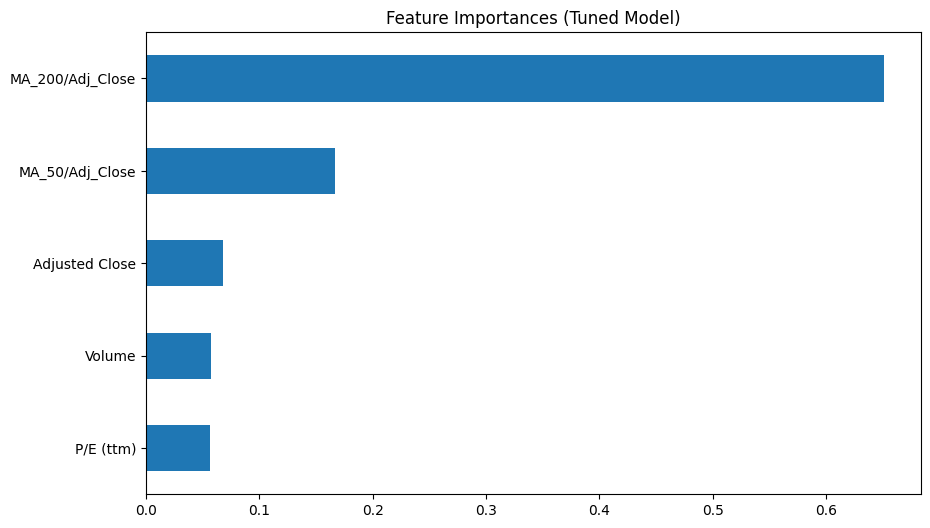

In [21]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

# Initial Cross-Validation
cv_scores = cross_val_score(model_rf_1, X_1, y_1, cv=5, scoring='r2')
print("Cross-validation scores:", cv_scores)
print("Mean CV score:", cv_scores.mean())
print("Standard deviation:", cv_scores.std())

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform Grid Search
grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=5,
    n_jobs=-1,
    scoring='r2'
)

# Fit Grid Search
grid_search.fit(X_1, y_1)

# Print results
print("\nBest parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Train final model with best parameters
best_rf = RandomForestRegressor(**grid_search.best_params_, random_state=42)
best_rf.fit(X_1, y_1)

# Compare original vs tuned model
print("\nOriginal model R² score:", model_rf_1.score(X_1, y_1))
print("Tuned model R² score:", best_rf.score(X_1, y_1))

# Plot feature importances of best model
feature_imp = pd.Series(best_rf.feature_importances_, index=features)
plt.figure(figsize=(10, 6))
feature_imp.sort_values().plot(kind='barh')
plt.title('Feature Importances (Tuned Model)')
plt.show()

Cross-Validation Scores: [-0.223272    0.28533283  0.33339698  0.19900715  0.24321432]
Mean CV Score: 0.1675358570286886
Best Parameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
Best CV Score: 0.22334327316090236


# Prophet

15:35:35 - cmdstanpy - INFO - Chain [1] start processing
15:35:36 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/47 [00:00<?, ?it/s]

15:35:36 - cmdstanpy - INFO - Chain [1] start processing
15:35:36 - cmdstanpy - INFO - Chain [1] done processing
15:35:36 - cmdstanpy - INFO - Chain [1] start processing
15:35:36 - cmdstanpy - INFO - Chain [1] done processing
15:35:36 - cmdstanpy - INFO - Chain [1] start processing
15:35:36 - cmdstanpy - INFO - Chain [1] done processing
15:35:36 - cmdstanpy - INFO - Chain [1] start processing
15:35:36 - cmdstanpy - INFO - Chain [1] done processing
15:35:36 - cmdstanpy - INFO - Chain [1] start processing
15:35:36 - cmdstanpy - INFO - Chain [1] done processing
15:35:36 - cmdstanpy - INFO - Chain [1] start processing
15:35:36 - cmdstanpy - INFO - Chain [1] done processing
15:35:37 - cmdstanpy - INFO - Chain [1] start processing
15:35:37 - cmdstanpy - INFO - Chain [1] done processing
15:35:37 - cmdstanpy - INFO - Chain [1] start processing
15:35:37 - cmdstanpy - INFO - Chain [1] done processing
15:35:37 - cmdstanpy - INFO - Chain [1] start processing
15:35:37 - cmdstanpy - INFO - Chain [1]

  horizon         mse       rmse       mae      mape     mdape     smape  \
0 37 days  166.546461  12.905288  8.127803  0.221241  0.154609  0.205541   
1 38 days  165.989398  12.883687  8.143034  0.225107  0.160148  0.208410   
2 39 days  165.553564  12.866762  8.168289  0.227899  0.160239  0.210383   
3 40 days  164.894595  12.841129  8.182487  0.229598  0.161521  0.211793   
4 41 days  166.181355  12.891135  8.225996  0.230891  0.161657  0.212832   

   coverage  
0  0.581993  
1  0.578006  
2  0.574911  
3  0.573666  
4  0.571655  


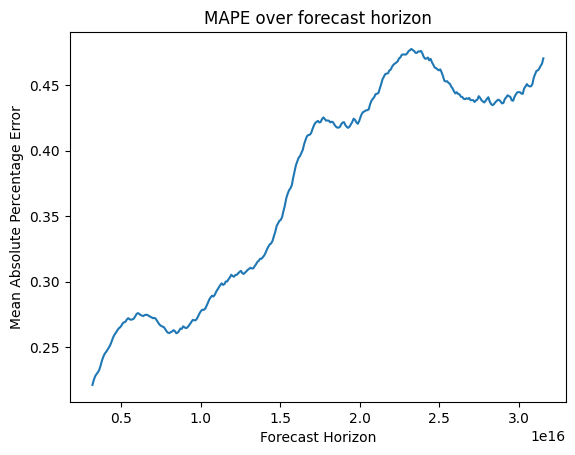

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/prophet/plot.py:546: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/prophet/plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


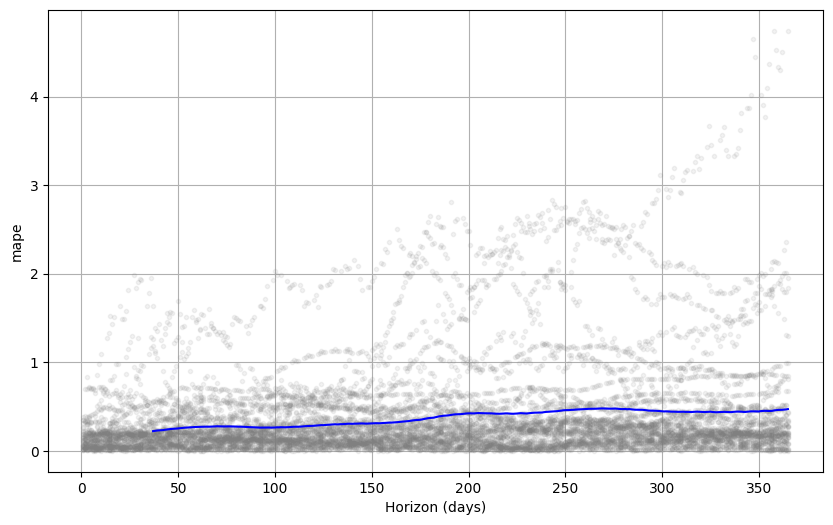

In [26]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from prophet.diagnostics import cross_validation, performance_metrics

# Read the data
df = pd.read_csv("../stocks_calc_final_with_ttm.csv")
df['Date'] = pd.to_datetime(df['Date'])

# Choose one stock (for example, the first stock)
sample_stock = df[df['Symbol'] == df['Symbol'].unique()[0]].copy()
sample_stock = sample_stock.sort_values('Date')

# Prepare data for Prophet
prophet_df = sample_stock[['Date', 'Adjusted Close']].rename(columns={'Date': 'ds', 'Adjusted Close': 'y'})

# Fit the model
model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False, changepoint_prior_scale=0.05)
model.fit(prophet_df)

# Backtesting using Prophet's cross_validation
# initial: period used for training before starting predictions
# period: frequency at which to make predictions
# horizon: forecast distance ahead to evaluate on
df_cv = cross_validation(model, initial='365 days', period='180 days', horizon='365 days')

# Compute performance metrics
df_p = performance_metrics(df_cv)
print(df_p.head())

# Plot performance metric (e.g., MAPE)
import seaborn as sns
sns.lineplot(data=df_p, x='horizon', y='mape')
plt.title('MAPE over forecast horizon')
plt.xlabel('Forecast Horizon')
plt.ylabel('Mean Absolute Percentage Error')
plt.show()

# Optional: Visualize cross-validation forecast vs actuals
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')
plt.show()

# ARIMA/LSTM

ADF Statistic: 0.73429350191134
p-value: 0.9904979857616755
Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0210 - val_loss: 0.0107
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 9.5085e-04 - val_loss: 0.0016
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0010 - val_loss: 0.0017
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8.8201e-04 - val_loss: 0.0014
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.6637e-04 - val_loss: 0.0013
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8.2382e-04 - val_loss: 9.6445e-04
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.2373e-04 - val_loss: 0.0018
Epoch 9/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.7558e-04 - val_loss: 9.1422e-04
Epoch 10/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 7.1779e-04 - val_loss: 0.0014
Epoch 11/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.9926e-04 - val_loss: 0.0015
Epoch 12/50
66/66 ━━━━━━━━━━━━━━━━

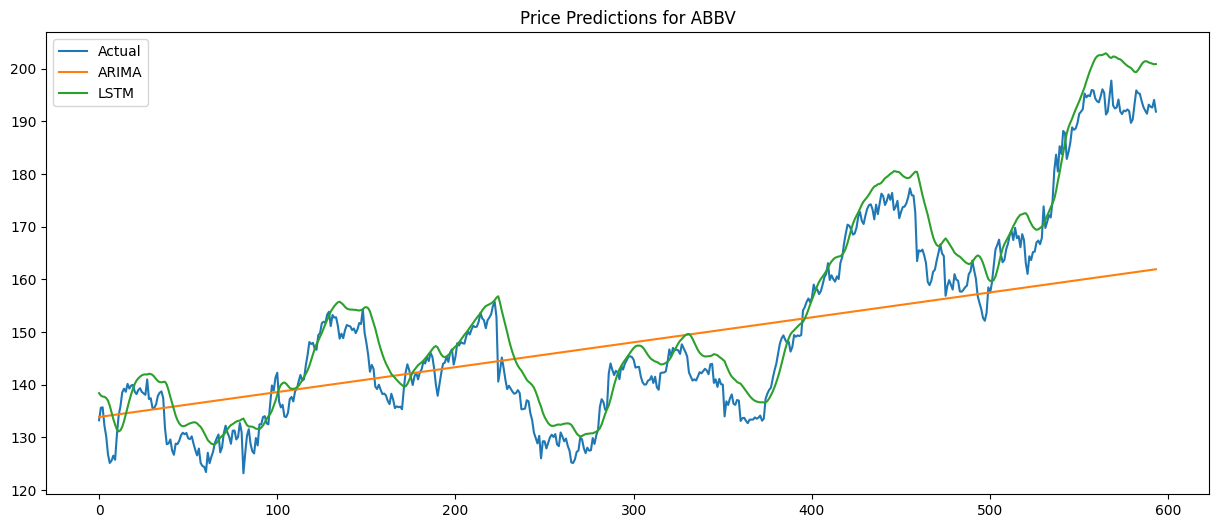


ARIMA Metrics:
MSE: 183.2290
RMSE: 13.5362
MAE: 10.4296
R2: 0.4875

LSTM Metrics:
MSE: 25.2802
RMSE: 5.0279
MAE: 4.0579
R2: 0.9293


In [6]:
# Import required libraries
import pandas as pd
import numpy as np
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

# Read and prepare data
df = pd.read_csv("../stocks_calc_final_with_ttm.csv")
df['Date'] = pd.to_datetime(df['Date'])

# Select one stock for example
stock_symbol = df['Symbol'].unique()[4]
sample_stock = df[df['Symbol'] == stock_symbol].sort_values('Date')
prices = sample_stock['Adjusted Close'].values

# Split data
train_size = int(len(prices) * 0.8)
train_data = prices[:train_size]
test_data = prices[train_size:]

# ARIMA Approach
def test_stationarity(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])

# Test stationarity
test_stationarity(prices)

# Find optimal ARIMA parameters
arima_model = auto_arima(train_data, 
                        start_p=0, start_q=0,
                        max_p=5, max_q=5,
                        seasonal=False,
                        stepwise=True,
                        suppress_warnings=True)

# Fit ARIMA and make predictions
arima_predictions = arima_model.predict(n_periods=len(test_data))

# LSTM Approach
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:(i + seq_length)])
        targets.append(data[i + seq_length])
    return np.array(sequences), np.array(targets)

# Scale data
scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(prices.reshape(-1, 1))

# Create sequences
seq_length = 60
X, y = create_sequences(scaled_prices, seq_length)

# Split sequences
X_train = X[:train_size-seq_length]
X_test = X[train_size-seq_length:]
y_train = y[:train_size-seq_length]
y_test = y[train_size-seq_length:]

# Build LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(seq_length, 1), return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Train LSTM
history = model.fit(X_train, y_train, 
                   epochs=50, 
                   batch_size=32,
                   validation_split=0.1,
                   verbose=1)

# Make predictions
lstm_predictions = model.predict(X_test)

# Compare Results
plt.figure(figsize=(15, 6))
plt.plot(test_data, label='Actual')
plt.plot(arima_predictions, label='ARIMA')
plt.plot(scaler.inverse_transform(lstm_predictions), label='LSTM')
plt.title(f'Price Predictions for {stock_symbol}')
plt.legend()
plt.show()

# Calculate metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def print_metrics(y_true, y_pred, model_name):
    print(f"\n{model_name} Metrics:")
    print(f"MSE: {mean_squared_error(y_true, y_pred):.4f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.4f}")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.4f}")
    print(f"R2: {r2_score(y_true, y_pred):.4f}")

print_metrics(test_data, arima_predictions, "ARIMA")
print_metrics(test_data, scaler.inverse_transform(lstm_predictions).flatten(), "LSTM")

ADF Statistic: -14.459353824628577
p-value: 6.88829126470996e-27

ARIMA (Differenced) Metrics:
MSE: 3082.2812
RMSE: 55.5183
MAE: 50.2210
R2: -4.3110


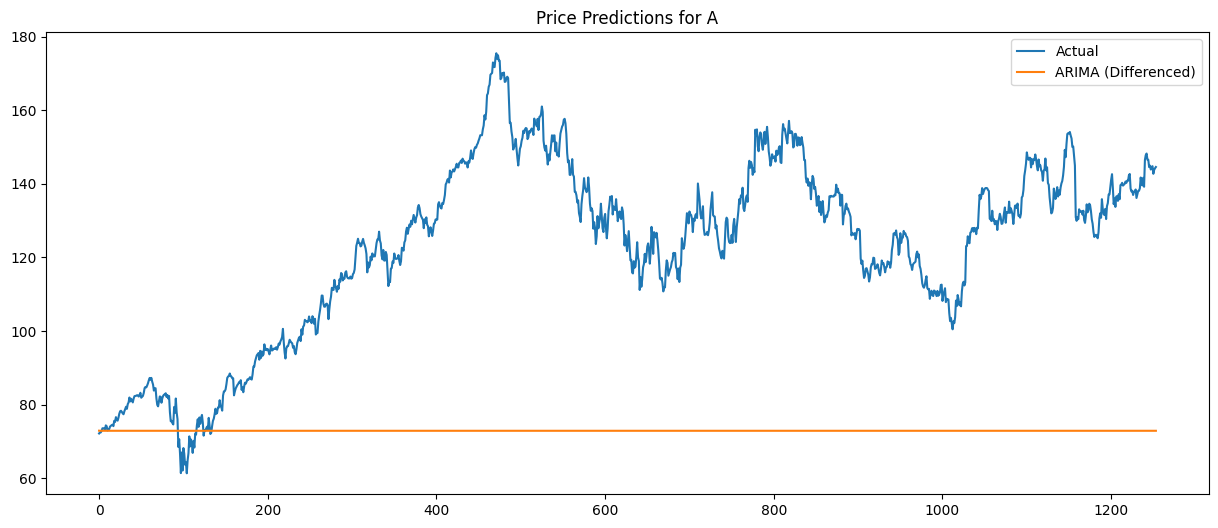

Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.0041 - val_loss: 0.0013
Epoch 2/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 5.0146e-04 - val_loss: 0.0011
Epoch 3/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 4.0433e-04 - val_loss: 5.1235e-04
Epoch 4/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 3.9758e-04 - val_loss: 2.4005e-04
Epoch 5/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 3.2803e-04 - val_loss: 2.2401e-04
Epoch 6/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 2.4389e-04 - val_loss: 1.5898e-04
Epoch 7/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 3.0238e-04 - val_loss: 9.8864e-04
Epoch 8/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 3.1873e-04 - val_loss: 3.7371e-04
Epoch 9/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 3.0530e-04 - val_loss: 1.9919e-04
Epoch 10/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 2.5259e-04 - val_loss: 3.9741e-04
Epoch 11/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 2.1544e-04

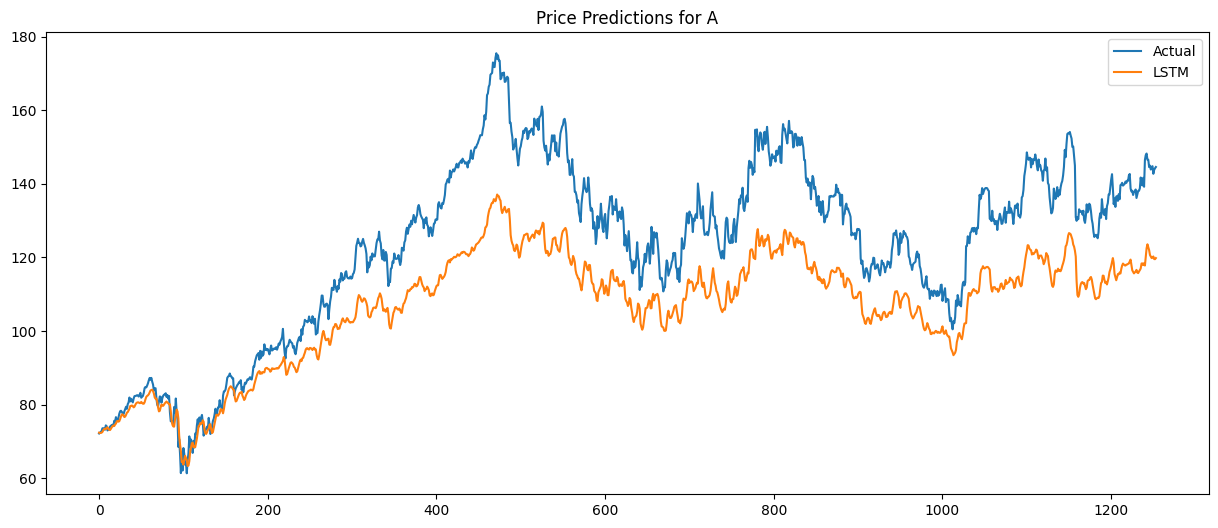

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Read and prepare data
df = pd.read_csv("../stocks_calc_final_with_ttm.csv")
df['Date'] = pd.to_datetime(df['Date'])

# Select one stock for example
stock_symbol = df['Symbol'].unique()[0]
sample_stock = df[df['Symbol'] == stock_symbol].sort_values('Date')
prices = sample_stock['Adjusted Close'].values

# Split data
train_size = int(len(prices) * 0.8)
train_data = prices[:train_size]
test_data = prices[train_size:]

# Scale data
scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(prices.reshape(-1, 1))

# Create sequences
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:(i + seq_length)])
        targets.append(data[i + seq_length])
    return np.array(sequences), np.array(targets)

seq_length = 60
X, y = create_sequences(scaled_prices, seq_length)

# Split sequences
X_train = X[:train_size-seq_length]
X_test = X[train_size-seq_length:]
y_train = y[:train_size-seq_length]
y_test = y[train_size-seq_length:]

# Differencing to make series stationary
diff_prices = np.diff(prices, n=1)

# Ensure consistent lengths
train_data_diff = diff_prices[:train_size-1]
test_data_diff = diff_prices[train_size-1:]

# Test stationarity
def test_stationarity(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])

test_stationarity(train_data_diff)

# Find optimal ARIMA parameters
arima_model_diff = auto_arima(train_data_diff, 
                              start_p=0, start_q=0,
                              max_p=5, max_q=5,
                              seasonal=False,
                              stepwise=True,
                              suppress_warnings=True)

# Fit ARIMA and make predictions
arima_predictions_diff = arima_model_diff.predict(n_periods=len(test_data_diff))

# Reverse differencing
arima_predictions_diff = np.r_[prices[train_size-1], arima_predictions_diff].cumsum()

# Ensure consistent lengths for evaluation
arima_predictions_diff = arima_predictions_diff[:len(test_data)]

# Evaluate performance
def print_metrics(y_true, y_pred, model_name):
    print(f"\n{model_name} Metrics:")
    print(f"MSE: {mean_squared_error(y_true, y_pred):.4f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.4f}")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.4f}")
    print(f"R2: {r2_score(y_true, y_pred):.4f}")

print_metrics(test_data, arima_predictions_diff, "ARIMA (Differenced)")

# Plot results
plt.figure(figsize=(15, 6))
plt.plot(test_data, label='Actual')
plt.plot(arima_predictions_diff, label='ARIMA (Differenced)')
plt.title(f'Price Predictions for {stock_symbol}')
plt.legend()
plt.show()

# Build LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(seq_length, 1), return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Train LSTM
history = model.fit(X_train, y_train, 
                   epochs=50, 
                   batch_size=32,
                   validation_split=0.1,
                   verbose=1)

# Make predictions
lstm_predictions = model.predict(X_test)

# Evaluate performance
print_metrics(test_data, scaler.inverse_transform(lstm_predictions).flatten(), "LSTM")

# Plot results
plt.figure(figsize=(15, 6))
plt.plot(test_data, label='Actual')
plt.plot(scaler.inverse_transform(lstm_predictions), label='LSTM')
plt.title(f'Price Predictions for {stock_symbol}')
plt.legend()
plt.show()

# LSTM on multiple symbols

Processing symbol: AAPL


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.02s - Debugger warning: It seems that frozen modules are being used, which may
0

KeyboardInterrupt: 

# LTSM w/ Fundamental Indicators

Processing symbol: AAPL
Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0027 - val_loss: 0.0057
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 3.9410e-04 - val_loss: 0.0029
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 3.0994e-04 - val_loss: 0.0015
Epoch 4/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 2.6748e-04 - val_loss: 0.0022
Epoch 5/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 2.4882e-04 - val_loss: 7.5636e-04
Epoch 6/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 2.0324e-04 - val_loss: 0.0011
Epoch 7/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 2.1057e-04 - val_loss: 0.0013
Epoch 8/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 2.1424e-04 - val_loss: 8.5093e-04
Epoch 9/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 1.7834e-04 - val_loss: 0.0012
Epoch 10/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 1.8784e-04 - val_loss: 0.0019
Epoch 11/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.8868e-04 - val_loss: 7.9183e-04
Epoch 12/50
83/83 ━━━━

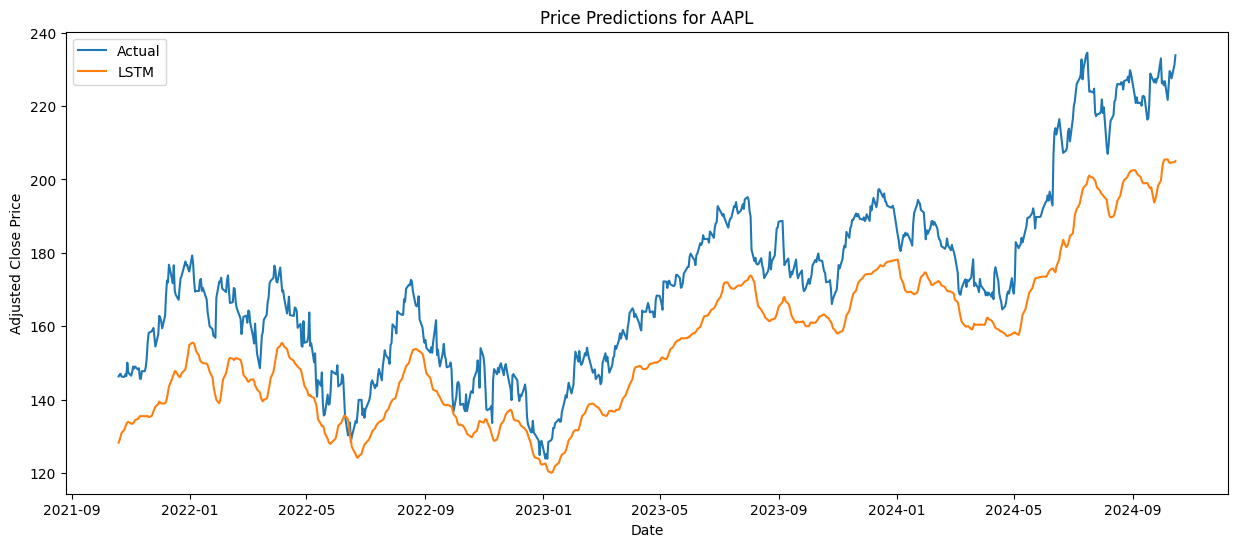

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Read and prepare data
df = pd.read_csv("../stocks_with_moving_averages_and_price_change.csv")
df['Date'] = pd.to_datetime(df['Date'])

# Select one stock symbol
symbol = df['Symbol'].unique()[2]
print(f"Processing symbol: {symbol}")

# Select data for the symbol
sample_stock = df[df['Symbol'] == symbol].sort_values('Date')
features = sample_stock[['Adjusted Close', 'Volume', 'P/E (ttm)', 'MA_50', 'MA_200']].values

# Split data
train_size = int(len(features) * 0.8)
train_data = features[:train_size]
test_data = features[train_size:]

# Scale data
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

# Create sequences
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:(i + seq_length)])
        targets.append(data[i + seq_length, 0])  # Predicting the Adjusted Close price
    return np.array(sequences), np.array(targets)

seq_length = 60
X, y = create_sequences(scaled_features, seq_length)

# Split sequences
X_train = X[:train_size-seq_length]
X_test = X[train_size-seq_length:]
y_train = y[:train_size-seq_length]
y_test = y[train_size-seq_length:]

# Build LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(seq_length, X.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Train LSTM
history = model.fit(X_train, y_train, 
                   epochs=50, 
                   batch_size=32,
                   validation_split=0.1,
                   verbose=1)

# Make predictions
lstm_predictions = model.predict(X_test)

# Inverse transform predictions
lstm_predictions = scaler.inverse_transform(np.concatenate((lstm_predictions, np.zeros((lstm_predictions.shape[0], scaled_features.shape[1] - 1))), axis=1))[:, 0]

# Evaluate performance
mse = mean_squared_error(test_data[:, 0], lstm_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data[:, 0], lstm_predictions)
r2 = r2_score(test_data[:, 0], lstm_predictions)

# Print metrics
def print_metrics(y_true, y_pred, model_name):
    print(f"\n{model_name} Metrics:")
    print(f"MSE: {mean_squared_error(y_true, y_pred):.4f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.4f}")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.4f}")
    print(f"R2: {r2_score(y_true, y_pred):.4f}")

print_metrics(test_data[:, 0], lstm_predictions, f"LSTM for {symbol}")

# Plot results
plt.figure(figsize=(15, 6))
plt.plot(sample_stock['Date'][train_size:], test_data[:, 0], label='Actual')
plt.plot(sample_stock['Date'][train_size:], lstm_predictions, label='LSTM')
plt.title(f'Price Predictions for {symbol}')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

# Prediction with LSTM


Backtesting Results:
Total Return: 22.58%
Sharpe Ratio: 0.39
Max Drawdown: -27.39%


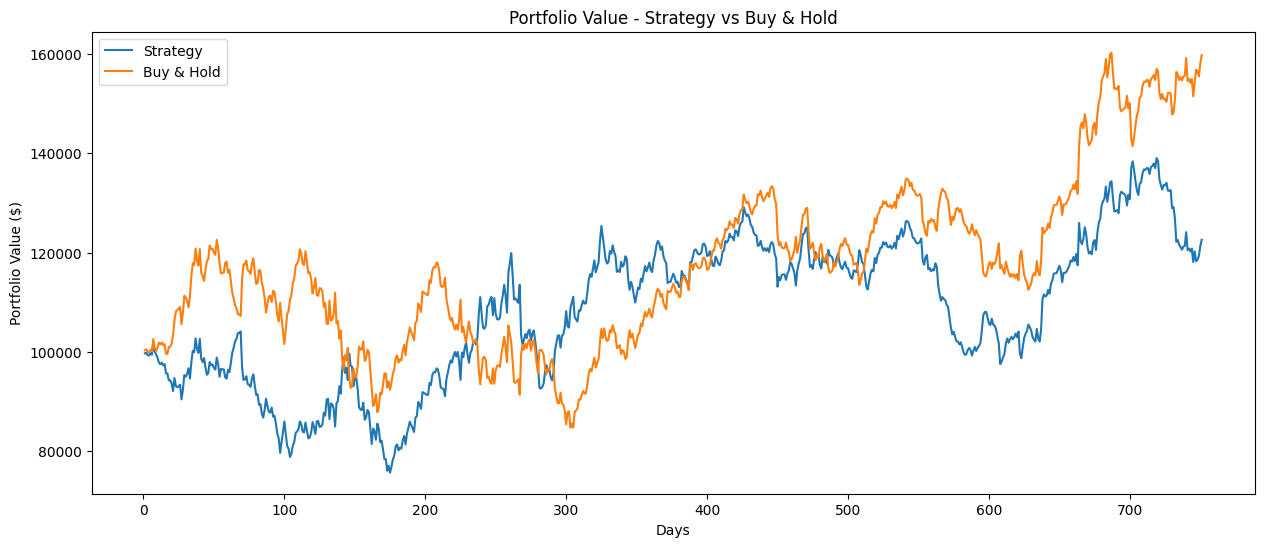

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

# Assuming we have our trained LSTM model and predictions from before
# ... existing LSTM code ...

def backtest_strategy(actual_prices, predicted_prices, initial_capital=100000):
    df = pd.DataFrame({
        'Actual': actual_prices,
        'Predicted': predicted_prices
    })
    
    # Calculate predicted returns
    df['Predicted_Return'] = df['Predicted'].pct_change()
    
    # Generate trading signals
    df['Position'] = np.where(df['Predicted_Return'] > 0, 1, -1)
    
    # Calculate strategy returns
    df['Actual_Return'] = df['Actual'].pct_change()
    df['Strategy_Return'] = df['Position'].shift(1) * df['Actual_Return']
    
    # Calculate portfolio value
    df['Portfolio_Value'] = initial_capital * (1 + df['Strategy_Return']).cumprod()
    
    # Calculate buy & hold returns
    df['Buy_Hold_Value'] = initial_capital * (1 + df['Actual_Return']).cumprod()
    
    # Calculate metrics
    total_return = (df['Portfolio_Value'].iloc[-1] - initial_capital) / initial_capital
    sharpe_ratio = np.sqrt(252) * (df['Strategy_Return'].mean() / df['Strategy_Return'].std())
    max_drawdown = (df['Portfolio_Value'] / df['Portfolio_Value'].cummax() - 1).min()
    
    print(f"\nBacktesting Results:")
    print(f"Total Return: {total_return*100:.2f}%")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Max Drawdown: {max_drawdown*100:.2f}%")
    
    # Plot results
    plt.figure(figsize=(15, 6))
    plt.plot(df['Portfolio_Value'], label='Strategy')
    plt.plot(df['Buy_Hold_Value'], label='Buy & Hold')
    plt.title('Portfolio Value - Strategy vs Buy & Hold')
    plt.xlabel('Days')
    plt.ylabel('Portfolio Value ($)')
    plt.legend()
    plt.show()
    
    return df

# Run backtest
backtest_results = backtest_strategy(test_data[:, 0], lstm_predictions)

# Hyperparameter Tuning

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Read and prepare data
df = pd.read_csv("../stocks_calc_final_with_ttm.csv")
df['Date'] = pd.to_datetime(df['Date'])

# Select one stock symbol
symbol = df['Symbol'].unique()[0]
print(f"Processing symbol: {symbol}")

# Select data for the symbol
sample_stock = df[df['Symbol'] == symbol].sort_values('Date')
features = sample_stock[['Adjusted Close', 'Volume', 'P/E (ttm)', 'MA_50', 'MA_200']].values

# Split data
train_size = int(len(features) * 0.8)
train_data = features[:train_size]
test_data = features[train_size:]

# Scale data
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

# Create sequences
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:(i + seq_length)])
        targets.append(data[i + seq_length, 0])  # Predicting the Adjusted Close price
    return np.array(sequences), np.array(targets)

seq_length = 60
X, y = create_sequences(scaled_features, seq_length)

# Split sequences
X_train = X[:train_size-seq_length]
X_test = X[train_size-seq_length:]
y_train = y[:train_size-seq_length]
y_test = y[train_size-seq_length:]

# Build LSTM model
model = Sequential([
    LSTM(100, activation='relu', input_shape=(seq_length, X.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(100, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Train LSTM
history = model.fit(X_train, y_train, 
                   epochs=100, 
                   batch_size=32,
                   validation_split=0.1,
                   verbose=1)

# Make predictions
lstm_predictions = model.predict(X_test)

# Inverse transform predictions
lstm_predictions = scaler.inverse_transform(np.concatenate((lstm_predictions, np.zeros((lstm_predictions.shape[0], scaled_features.shape[1] - 1))), axis=1))[:, 0]

# Evaluate performance
mse = mean_squared_error(test_data[:, 0], lstm_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data[:, 0], lstm_predictions)
r2 = r2_score(test_data[:, 0], lstm_predictions)

# Print metrics
def print_metrics(y_true, y_pred, model_name):
    print(f"\n{model_name} Metrics:")
    print(f"MSE: {mean_squared_error(y_true, y_pred):.4f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.4f}")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.4f}")
    print(f"R2: {r2_score(y_true, y_pred):.4f}")

print_metrics(test_data[:, 0], lstm_predictions, f"LSTM for {symbol}")

# Plot results
plt.figure(figsize=(15, 6))
plt.plot(sample_stock['Date'][train_size:], test_data[:, 0], label='Actual')
plt.plot(sample_stock['Date'][train_size:], lstm_predictions, label='LSTM')
plt.title(f'Price Predictions for {symbol}')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()